# 01_Data_Preprocessing.ipynb

## 1. Environment Setup & Imports

In [21]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# utilities
import re
from joblib import dump

# download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# set styles
sns.set(style="whitegrid")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Load Raw Data

In [22]:
df1 = pd.read_excel('FeedbacksDetails.xlsx')
df2 = pd.read_excel('FeedbacksDetailsBatch_16_17.xlsx')
print("Raw Semester A columns:", df1.columns.tolist())
print("Raw Semester B columns:", df2.columns.tolist())


Raw Semester A columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']
Raw Semester B columns: ['Batch 17', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9']


## 3. Schema Standardization (Header Alignment)

In [24]:
def clean_header(cols):
    """Lowercase, strip whitespace, replace non-alphanumeric with underscore."""
    new = []
    for c in cols:
        c = c.strip().lower()
        c = re.sub(r'[^\w\s]', '_', c)
        c = re.sub(r'\s+', '_', c)
        new.append(c)
    return new

# apply to both
df1.columns = clean_header(df1.columns)
df2.columns = clean_header(df2.columns)

# unify schema: add any missing column to each DF
all_cols = set(df1.columns) | set(df2.columns)
for c in all_cols:
    if c not in df1.columns: df1[c] = pd.NA
    if c not in df2.columns: df2[c] = pd.NA

# reorder
df2 = df2[df1.columns]

print("Unified columns:", df1.columns.tolist())


Unified columns: ['unnamed__0', 'unnamed__1', 'unnamed__2', 'unnamed__3', 'unnamed__4', 'unnamed__5', 'unnamed__6', 'unnamed__7', 'unnamed__8', 'unnamed__9', 'unnamed__10', 'batch_17']


## 4. Missing-Value & Irrelevant Column Handling


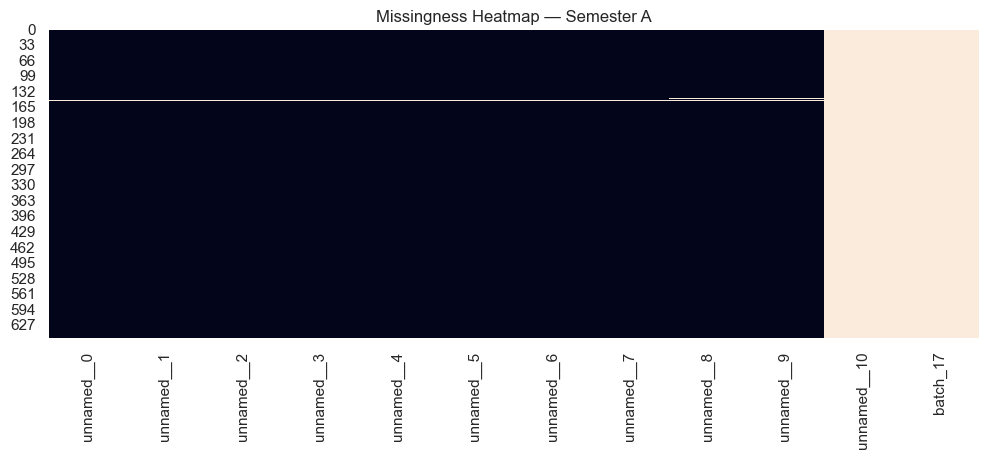

Dropped columns: ['unnamed__0', 'batch_17', 'unnamed__10']
Remaining columns: ['unnamed__1', 'unnamed__2', 'unnamed__3', 'unnamed__4', 'unnamed__5', 'unnamed__6', 'unnamed__7', 'unnamed__8', 'unnamed__9']


In [25]:
# Visualize missingness in Semester A
plt.figure(figsize=(12,4))
sns.heatmap(df1.isna(), cbar=False)
plt.title('Missingness Heatmap — Semester A')
plt.show()

# 4.1 Drop cols >50% missing in either DF
thr = 0.5
drop_cols = [c for c in df1 if (df1[c].isna().mean()>thr or df2[c].isna().mean()>thr)]
# 4.2 Drop constant cols
drop_cols += [c for c in df1 if df1[c].nunique()<=1]
# 4.3 Drop identifier-like columns
drop_cols += [c for c in df1 if 'id' in c or 'email' in c]
drop_cols = list(set(drop_cols))

df1.drop(columns=drop_cols, inplace=True)
df2.drop(columns=drop_cols, inplace=True)
print("Dropped columns:", drop_cols)
print("Remaining columns:", df1.columns.tolist())

# Remove rows without any free-text feedback
text_cols = [c for c in df1.columns if df1[c].dtype=='object']
df1 = df1.dropna(subset=text_cols, how='all')
df2 = df2.dropna(subset=text_cols, how='all')


## 5. Basic Text Cleaning Function


In [26]:
def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r'https?://\S+', ' ', text)           # remove URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)            # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()            # collapse whitespace
    return text


## 6. NLP Preprocessing Pipeline


In [27]:
# init NLP components
stop_words = set(stopwords.words('english'))
# add domain-specific stopwords if desired
stop_words.update(['internship','experience','expectation','company'])

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    # map NLTK POS tags to WordNet POS for better lemmatization
    # (here simplified: assume nouns for all)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

# apply to each free-text column and store cleaned tokens
for col in text_cols:
    clean_col = f"{col}_clean_tokens"
    df1[clean_col] = df1[col].apply(preprocess_text)
    df2[clean_col] = df2[col].apply(preprocess_text)

# Example: visualize token count distribution
df1['token_count'] = df1[text_cols[0] + '_clean_tokens'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df1['token_count'], bins=30)
plt.title('Token Count Distribution (Semester A)')
plt.xlabel('Number of Tokens')
plt.show()


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\piyum/nltk_data'
    - 'C:\\Users\\piyum\\PycharmProjects\\ML_Project\\.venv\\nltk_data'
    - 'C:\\Users\\piyum\\PycharmProjects\\ML_Project\\.venv\\share\\nltk_data'
    - 'C:\\Users\\piyum\\PycharmProjects\\ML_Project\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\piyum\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


## 7. Save Preprocessed Data & Text Processor


In [28]:
# concatenate cohorts
cleaned = pd.concat([df1, df2], ignore_index=True)

# save to Excel for downstream notebooks
cleaned.to_excel('cleaned_feedback_preprocessed.xlsx', index=False)

# save text-processor helper functions for reuse
dump(clean_text, 'models/clean_text.fn')
dump(preprocess_text, 'models/preprocess_text.fn')


['models/preprocess_text.fn']